In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import chi2 ,mutual_info_classif
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,precision_score,accuracy_score,roc_curve, plot_confusion_matrix, precision_recall_curve,recall_score,f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import datetime as dt
from datetime import timedelta
import lifetimes
from lifetimes import utils
from functools import reduce
import shap
import scipy.stats as stats
from pandas.util._decorators import Appender
from statsmodels.compat.pandas import Appender
#import statsmodels.api as sm

In [ ]:
Customer_Data = pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/file (4)/Customer_Data.xlsx")
Invoice_Data  = pd.read_csv("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/file (4)/Final_invoice.csv")
Plant_Data    = pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/file (4)/Plant Master.xlsx")
Material_Data = pd.read_csv("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/file (4)/JTD.csv")


In [ ]:
df = pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/Model_Data.xlsx")

In [ ]:
df['tripdate'] = pd.to_datetime(df['JobCard_Date'], format = '%Y%m%d')

In [ ]:
# Create snapshot date
snapshot_date = df['tripdate'].max() + timedelta(days=1)

In [ ]:
#Grouping by Customer_ID

df_process = df.groupby(['Customer_ID']).agg({
        'tripdate': lambda x: (snapshot_date - x.max()).days,
        'Customer_ID': lambda x: len(x),
        'Total_Amt': lambda x: x.sum()})



In [ ]:
df_process.rename(columns={'tripdate': 'Recency',
                         'Customer_ID': 'Frequency',
                         'Total_Amt': 'MonetaryValue'}, inplace=True)


In [ ]:
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_process['Recency'])

# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_process['Frequency'])

# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_process['MonetaryValue'])


In [ ]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1)
f_labels = range(1, 3)
# Assign these labels to 3 equal percentile groups 
r_groups = pd.qcut(df_process['Recency'], q=3, labels=r_labels, duplicates = 'drop')
# Assign these labels to 3 equal percentile groups 
f_groups = pd.qcut(df_process['Frequency'], q=3, labels=f_labels, duplicates = 'drop')

df_process = df_process.assign(R = r_groups.values, F = f_groups.values)
df_process.head()

# Create labels for MonetaryValue
m_labels = range(1, 4)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(df_process['MonetaryValue'], q=3, labels=m_labels, duplicates = 'drop')
# Create new column M
df_process = df_process.assign(M = m_groups.values)

# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
  return str(x['R']) + str(x['F']) + str(x['M'])
df_process['RFM_Segment_Concat'] = df_process.apply(join_rfm, axis=1)
rfm = df_process
rfm.head()

# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

rfm['RFM_Score'].unique()

In [ ]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Lose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
      
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': ['mean', np.median, 'min' , 'max'],
    'Frequency': ['mean', np.median, 'min' , 'max'],
    'MonetaryValue': ['mean', np.median, 'min' , 'max', 'count']}).round(1)

rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','RecencyMedian','RecencyMin','RecencyMax',
                         'FrequencyMean','FrequencyMedian','FrequencyMin','FrequencyMax',
                         'MonetaryMean','MonetaryMedian','MonetaryMin','MonetaryMax', 'Count']
rfm_level_agg.sort_values(by =['MonetaryMean'], ascending= False, inplace = True)
print(rfm_level_agg)
rfm_level_agg.shape

In [ ]:
## Visualization
#Create our plot and resize it.
plt.pie(rfm_level_agg['Count'],labels=['Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'],autopct='%1.0f%%')

# Predicting 'Alive Probability' of customer -  BG-NBD Model

In [ ]:
df_trans = df[['Customer_ID','JobCard_Date','Total_Amt']]

In [ ]:
df_trans['tripdate'] = pd.to_datetime(df_trans['JobCard_Date'], format = '%Y%m%d')

In [ ]:
df_trans['tripdate'].max() + timedelta(1)

In [ ]:
df_trans['tripdate'] 

In [ ]:
#summary = utils.summary_data_from_transaction_data(df_trans, 'Customer_ID','tripdate','Total_Amt', observation_period_end = '2016-11-01')
summary = utils.summary_data_from_transaction_data(df_trans, 'Customer_ID','tripdate','Total_Amt')

In [ ]:
summary = summary.reset_index()

In [ ]:
summary_OTB = summary.loc[(summary['frequency']==0) & (summary['recency']==0)]

In [ ]:
one_time_buyers = round(summary_OTB.shape[0]/summary.shape[0] *100 ,2)
one_time_buyers

In [ ]:
summary['frequency'].plot(kind = 'hist', bins = 200)

In [ ]:
pd.DataFrame(summary['frequency'].value_counts())

In [ ]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef= 0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

In [ ]:
bgf.summary

In [ ]:
summary['alive_prob'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

In [ ]:
summary.loc[summary['alive_prob']<0.40]

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize = (20,10) )
plot_frequency_recency_matrix(bgf)

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize = (20,10) )
plot_probability_alive_matrix(bgf)

In [ ]:
t = 30
summary['pred_num_visits'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

summary[['monetary_value', 'frequency']].corr()


return_purchase_cus = summary[summary['frequency']>0]
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_purchase_cus['frequency'],return_purchase_cus['monetary_value'])

summary = summary[summary['monetary_value']>0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value'])

In [ ]:
rfm = rfm.reset_index()

In [ ]:
summary.columns = ['Unnamed: 0', 'Customer_ID', 'frequency_bgnbd', 'recency_bgnbd', 'T',
       'monetary_value_ori', 'monetary_value', 'alive_prob']

In [ ]:
rfm_aliveprob = rfm.merge(summary, how='left', on = 'Customer_ID')

In [ ]:
rfm_aliveprob.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [ ]:
rfm_aliveprob_ =  rfm_aliveprob[['Customer_ID', 'Recency', 'Frequency', 'MonetaryValue', 
       'RFM_Segment_Concat', 'RFM_Score', 'RFM_Level',
       'alive_prob']]

In [ ]:
rfm_aliveprob_

# Calculate CLV

# CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

# Customer Value = Average Order Value * Purchase Frequency

In [ ]:
# Average Order Value
rfm_aliveprob['avg_order_value']=rfm_aliveprob['MonetaryValue']/rfm_aliveprob['Frequency']

#Calculate Purchase Frequency
purchase_frequency=sum(rfm_aliveprob['Frequency'])/rfm_aliveprob.shape[0]

#Calculate Repeat Rate and Churn Rate
repeat_rate=rfm_aliveprob[rfm_aliveprob.Frequency > 1].shape[0]/rfm_aliveprob.shape[0]

#Churn Rate
churn_rate=1-repeat_rate

In [ ]:
# Customer Value
rfm_aliveprob['CLV']=(rfm_aliveprob['avg_order_value']*purchase_frequency)/churn_rate

# Profit Margin
rfm_aliveprob['profit_margin']=rfm_aliveprob['MonetaryValue']*0.02

#Customer Lifetime Value
rfm_aliveprob['cust_lifetime_value']=rfm_aliveprob['CLV']*rfm_aliveprob['profit_margin']

rfm_aliveprob['cust_lifetime_value'] = round(rfm_aliveprob['cust_lifetime_value'],2)

In [ ]:
rfm_aliveprob

In [ ]:
rfm_aliveprob_ =  rfm_aliveprob[['Customer_ID', 'Recency', 'Frequency', 'MonetaryValue', 'T',
       'RFM_Segment_Concat', 'RFM_Score', 'RFM_Level',
       'alive_prob','cust_lifetime_value']]

In [ ]:
rfm_aliveprob_

In [ ]:
rfm_aliveprob_['Lapsed'] = np.nan
rfm_aliveprob_.loc[ rfm_aliveprob_['alive_prob'] <= 0.4, 'Lapsed'] = 1
rfm_aliveprob_.loc[ rfm_aliveprob_['alive_prob'] > 0.4, 'Lapsed'] = 0


In [ ]:
rfm_aliveprob_['Lapsed'].value_counts()

In [ ]:
rfm_aliveprob_

In [ ]:
# Create labels for MonetaryValue
clv_labels = range(1, 4)
# Assign these labels to three equal percentile groups 
clv_groups = pd.qcut(rfm_aliveprob_['cust_lifetime_value'], q=3, labels=clv_labels, duplicates = 'drop')
rfm_aliveprob_ = rfm_aliveprob_.assign(clv_groups = clv_groups.values)

In [ ]:
rfm_aliveprob_['clv_groups'].value_counts()

In [ ]:
rfm_aliveprob_agg = rfm_aliveprob_.groupby('clv_groups').agg({
    'cust_lifetime_value': ['mean', np.median, 'min' , 'max']}).round(1)

rfm_aliveprob_agg

In [ ]:
rfm_aliveprob_['cltv_groups'] = np.nan
rfm_aliveprob_.loc[ rfm_aliveprob_['clv_groups'] == 1 , 'cltv_groups'] = 'Low'
rfm_aliveprob_.loc[ rfm_aliveprob_['clv_groups'] == 2, 'cltv_groups'] = 'Medium'
rfm_aliveprob_.loc[ rfm_aliveprob_['clv_groups'] == 3, 'cltv_groups'] = 'High'

In [ ]:
rfm_aliveprob_

In [ ]:
rfm_aliveprob_.to_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/rfm_aliveprob_.xlsx")

In [ ]:
plt.figure(figsize=(20,10))
sns.violinplot(y = 'cust_lifetime_value', x= clv_groups, data =rfm_aliveprob_ )

In [3]:
df =  pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/Feature_creation.xlsx")

In [4]:
df_state = pd.pivot_table(df, values='Visits_no', index=['Customer No.'],
                    columns=['State'], aggfunc='count')
df_state.replace(np.nan,0, inplace=True)
df_state[df_state != 0] = 1

In [5]:
df_make = pd.pivot_table(df, values='Visits_no', index=['Customer No.'],
                    columns=['Make'], aggfunc='count')

df_make.replace(np.nan,0, inplace=True)
df_make[df_make != 0] = 1

In [6]:
df_ = df.copy()

df_.loc[ (df_['Visits_no'] > 100), 'Visits_no'] = 101

df_mm = pd.pivot_table(df, values='Visits_no', index=['Customer No.'],
                    columns=['Make_Model'], aggfunc='count')

df_mm.replace(np.nan,0, inplace=True)
df_mm[df_mm != 0] = 1

In [7]:
df_visit_km = pd.pivot_table(df_, values='KMs Reading', index=['Customer No.'],
                    columns=['Visits_no'], aggfunc=np.mean)

df_visit_km.replace(np.nan,0, inplace=True)

In [8]:
df_visit_ST = pd.pivot_table(df_, values='Hrs_servicetime', index=['Customer No.'],
                    columns=['Visits_no'], aggfunc=np.mean)

df_visit_ST.replace(np.nan,0, inplace=True)

In [9]:
df_visit_km = df_visit_km.add_prefix('km_read_Visit_')
df_visit_ST = df_visit_ST.add_prefix('Servicetime_Visit_')

In [10]:
df_visit_amt = pd.pivot_table(df_, values='Total_Amt', index=['Customer No.'],
                    columns=['Visits_no'], aggfunc=np.mean)

df_visit_amt.replace(np.nan,0, inplace=True)
df_visit_amt = df_visit_amt.add_prefix('Total_Amt_Visit_')

In [11]:
df_plant = pd.pivot_table(df, values='Visits_no', index=['Customer No.'],
                    columns=['Plant'], aggfunc='count')

df_plant.replace(np.nan,0, inplace=True)
df_plant[df_plant != 0] = 1

In [15]:
mod_df =  pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/model_df.xlsx")

In [16]:

mod_df.replace(np.nan,0, inplace=True)
mod_df.columns =['Customer No.', 'No_of_Visits', 'Accidental', 'Mechanical',
       'Paid_Service', 'Repeat_Order', 'Running_Repairs', 'SMC_Redemption',
       'SMC_Value_Package', 'WBW_Order', 'Workshop_Damage']

mod_df.loc[mod_df['Accidental'] >0 , 'Accidental'] =1 
mod_df.loc[mod_df['Mechanical'] >0 , 'Mechanical'] =1 
mod_df.loc[mod_df['Paid_Service'] >0 , 'Paid_Service'] =1 
mod_df.loc[mod_df['Repeat_Order'] >0 , 'Repeat_Order'] =1 
mod_df.loc[mod_df['Running_Repairs'] >0 , 'Running_Repairs'] =1 
mod_df.loc[mod_df['SMC_Redemption'] >0 , 'SMC_Redemption'] =1
mod_df.loc[mod_df['SMC_Value_Package'] >0 , 'SMC_Value_Package'] =1
mod_df.loc[mod_df['WBW_Order'] >0 , 'WBW_Order'] =1
mod_df.loc[mod_df['Workshop_Damage'] >0 , 'Workshop_Damage'] =1

In [ ]:
df_visit_kMperch = df_visit_km.pct_change(axis=1)*100
df_visit_kMperch.replace(np.nan, 0, inplace= True)
df_visit_kMperch[df_visit_kMperch < 0] = 0
df_visit_kMperch.drop(['km_read_Visit_1'], axis = 1 , inplace= True)
df_visit_kMperch = df_visit_kMperch.add_prefix('ch_')
df_visit_kMperch.reset_index(inplace= True)

In [19]:
df_visit_km.reset_index(inplace= True)
df_plant.reset_index(inplace= True)
df_mm.reset_index(inplace= True)
df_state.reset_index(inplace= True)
df_visit_ST.reset_index(inplace= True)
df_visit_amt.reset_index(inplace= True)

In [20]:
log_df3 = pd.pivot_table(df, values=['Hrs_servicetime', 'KMs Reading','Total_Amt'], index=['Customer No.'],
                    aggfunc={'Hrs_servicetime': np.mean,
                             'KMs Reading': np.mean,
                            'Total_Amt': np.mean})
log_df3.reset_index(inplace= True)

In [21]:
model_df= reduce(lambda x,y: pd.merge(x,y, on='Customer No.', how='inner'), [mod_df,df_state, df_plant, df_mm,df_visit_km,df_visit_ST,df_visit_amt,log_df3])

In [22]:
rfm_aliveprob_cltv =  pd.read_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/rfm_aliveprob_cltv.xlsx")

In [23]:
lapsed = rfm_aliveprob_cltv[['Customer_ID','Lapsed']]
cltv = rfm_aliveprob_cltv[['Customer_ID','clv_groups']]
lapsed.columns =['Customer No.', 'Lapsed']
cltv.columns = ['Customer No.', 'clv_groups']

In [24]:
modeldf_C = model_df.merge(lapsed, how= 'left' , on = 'Customer No.')
modeldf_Cltv = model_df.merge(cltv, how= 'left' , on = 'Customer No.')    

In [ ]:
modeldf_C.columns.to_list()

In [25]:
modeldf_C = modeldf_C[['Customer No.',  'No_of_Visits',  'Accidental',  'Mechanical',  'Paid_Service',  'Repeat_Order',  'Running_Repairs',  'SMC_Redemption',  'SMC_Value_Package',  'WBW_Order',  'Workshop_Damage',  'andaman_and_nicobar',  'andhra_pradesh',  'arunachal_pradesh',  'assam',  'bihar',  'chandigarh',  'chhattisgarh',  'dadra_and_nagar_hav',  'daman_and_diu',  'delhi',  'goa',  'gujarat',  'haryana',  'himachal_pradesh',  'jammu_and_kashmir',  'jharkhand',  'karnataka',  'kerala',  'lakshadweep',  'madhya_pradesh',  'maharashtra',  'manipur',  'megalaya',  'mizoram',  'nagaland',  'odisha',  'puducherry',  'punjab',  'rajasthan',  'sikkim',  'tamil_nadu',  'telangana',  'tripura',  'uttar_pradesh',  'uttarakhand',  'west_bengal',  'BC01',  'BC02',  'BC03',  'BC04',  'BC05',  'BC06',  'BC07',  'BC08',  'BC11',  'BC12',  'BC13',  'BC15',  'BC16',  'BC17',  'BC18',  'BC19',  'BC20',  'BC21',  'BC22',  'BC23',  'BC24',  'BC25',  'BC26',  'BC27',  'BC28',  'BC29',  'BC30',  'BC31',  'BC32',  'BC33',  'BC34',  'X001',  'X003',  'X005',  'X006',  'X007',  'X008',  'X010',  'X011',  'X012',  'X013',  'X014',  'X016',  'X017',  'X018',  'X020',  'X021',  'X022',  'X023',  'X024',  'X025',  'X026',  'X027',  'X028',  'X029',  'X031',  'X032',  'X033',  'X034',  'X035',  'X036',  'X037',  'X039',  'X041',  'X042',  'X044',  'X045',  'X046',  'X047',  'X048',  'X049',  'X050',  'X051',  'X052',  'X053',  'X054',  'X055',  'X056',  'X057',  'X058',  'X060',  'X061',  'X062',  'X063',  'X064',  'X066',  'X068',  'X072',  'X073',  'X074',  'X075',  'X076',  'X079',  'X080',  'X081',  'X082',  'X083',  'X084',  'X085',  'X086',  'X089',  'X091',  'X092',  'X095',  'X098',  'X099',  'X101',  'X102',  'X103',  'X105',  'X106',  'X107',  'X109',  'X110',  'X111',  'X112',  'X113',  'X114',  'X118',  'X119',  'X121',  'X122',  'X123',  'X124',  'X125',  'X126',  'X127',  'X128',  'X129',  'X131',  'X132',  'X133',  'X135',  'X136',  'X138',  'X139',  'X140',  'X146',  'X147',  'X149',  'X154',  'X155',  'X156',  'X161',  'X164',  'X166',  'X167',  'X169',  'X170',  'X171',  'X172',  'X173',  'X174',  'X175',  'X177',  'X180',  'X183',  'X185',  'X186',  'X187',  'X188',  'X190',  'X192',  'X196',  'X199',  'X201',  'X202',  'X203',  'X204',  'X205',  'X206',  'X209',  'X211',  'X214',  'X215',  'X217',  'X218',  'X219',  'X224',  'X229',  'X233',  'X238',  'X241',  'X242',  'X243',  'X244',  'X245',  'X246',  'X247',  'X249',  'X252',  'X253',  'X254',  'X259',  'X260',  'X261',  'X264',  'X265',  'X267',  'X269',  'X270',  'X277',  'X279',  'X281',  'X285',  'X286',  'X297',  'X308',  'X316',  'X317',  'X320',  'X322',  'X324',  'X327',  'X328',  'X329',  'X331',  'X332',  'X334',  'X339',  'X341',  'X347',  'X350',  'X357',  'X359',  'X364',  'X366',  'X380',  'X384',  'X386',  'X392',  'X397',  'X401',  'X403',  'X405',  'X413',  'X418',  'X432',  'X435',  'X437',  'X444',  'X458',  'AUDI_A4',  'AUDI_A6',  'AUDI_A7',  'AUDI_A8',  'AUDI_Q5',  'AUDI_Q7',  'AUDI_TT',  'BMW_',  'BMW_3_SERIES',  'BMW_5_SERIES',  'BMW_6_SERIES',  'BMW_7_SERIES',  'BMW_BMW',  'BMW_MINIS',  'BMW_X1',  'BMW_X3',  'BMW_X5',  'BMW_Z4',  'DAEWOO_CIELO',  'DAEWOO_MATIZ',  'DAEWOO_NEXIA',  'FIAT_',  'FIAT_500',  'FIAT_ADVENTURE',  'FIAT_GRAND',  'FIAT_LINEA',  'FIAT_PALIO',  'FIAT_PETRA',  'FIAT_SIENA',  'FIAT_UNO',  'FORCE_FORCE_ONE',  'FORCE_TRAX',  'FORD_',  'FORD_ECOSPORT',  'FORD_ECO_SPORT',  'FORD_ENDEAVOUR',  'FORD_ESCORT',  'FORD_FIESTA',  'FORD_FIGO',  'FORD_FOCUS',  'FORD_FUSION',  'FORD_IKON',  'FORD_LIMOUSINE',  'FORD_MONDEO',  'GENERAL_MOTORS_',  'GENERAL_MOTORS_AVEO',  'GENERAL_MOTORS_BEAT',  'GENERAL_MOTORS_CAPTIVA',  'GENERAL_MOTORS_CHEVROLET_CRUZE',  'GENERAL_MOTORS_ENJOY',  'GENERAL_MOTORS_FORESTER',  'GENERAL_MOTORS_OPEL',  'GENERAL_MOTORS_OPEL_ASTRA',  'GENERAL_MOTORS_OPTRA',  'GENERAL_MOTORS_OPTRA_MAGNUM',  'GENERAL_MOTORS_SAIL',  'GENERAL_MOTORS_SPARK',  'GENERAL_MOTORS_SRV',  'GENERAL_MOTORS_TAVERA',  'GENERAL_MOTORS_TAVERA_NEO',  'GENERAL_MOTORS_TRAILBLAZER',  'GENERAL_MOTORS_VECTRA',  'HINDUSTAN_MOTORS_AMBASSADOR',  'HINDUSTAN_MOTORS_AVIGO',  'HINDUSTAN_MOTORS_CONTESSA',  'HINDUSTAN_MOTORS_GRAND',  'HINDUSTAN_MOTORS_PUSHPAK',  'HINDUSTAN_MOTORS_TREKKER',  'HONDA_',  'HONDA_ACCORD',  'HONDA_AMAZE',  'HONDA_BRIO',  'HONDA_BRV',  'HONDA_CITY',  'HONDA_CIVIC',  'HONDA_CR_V',  'HONDA_JAZZ',  'HONDA_MOBILIO',  'HONDA_SAIL',  'HYUNDAI_',  'HYUNDAI_ACCENT',  'HYUNDAI_ALTO',  'HYUNDAI_CRETA',  'HYUNDAI_ELANTRA',  'HYUNDAI_EON',  'HYUNDAI_GETZ',  'HYUNDAI_I10',  'HYUNDAI_I20',  'HYUNDAI_SANTA_FE',  'HYUNDAI_SANTRO',  'HYUNDAI_SONATA',  'HYUNDAI_SONATA_V_6',  'HYUNDAI_TERRACAN',  'HYUNDAI_TUCSON',  'HYUNDAI_VELOSTER',  'HYUNDAI_VERNA',  'HYUNDAI_XCENT',  'JEEP_CHEROKEE',  'LAND_ROVER_ROVER',  'MAHINDRA_&_MAHINDRA_',  'MAHINDRA_&_MAHINDRA_ARMADA',  'MAHINDRA_&_MAHINDRA_BOLERO',  'MAHINDRA_&_MAHINDRA_CLASSIC',  'MAHINDRA_&_MAHINDRA_COMMANDER',  'MAHINDRA_&_MAHINDRA_GENIO',  'MAHINDRA_&_MAHINDRA_KUV100',  'MAHINDRA_&_MAHINDRA_LOGAN',  'MAHINDRA_&_MAHINDRA_MAHINDRA_CNG',  'MAHINDRA_&_MAHINDRA_MAHINDRA_MM',  'MAHINDRA_&_MAHINDRA_MAHINDRA_PIK_UP',  'MAHINDRA_&_MAHINDRA_MARSHAL',  'MAHINDRA_&_MAHINDRA_MAXX',  'MAHINDRA_&_MAHINDRA_MAXXIMO',  'MAHINDRA_&_MAHINDRA_QUANTO',  'MAHINDRA_&_MAHINDRA_REVA',  'MAHINDRA_&_MAHINDRA_SCORPIO',  'MAHINDRA_&_MAHINDRA_SSANYONG_KORANDO',  'MAHINDRA_&_MAHINDRA_SSANYONG_REXTON',  'MAHINDRA_&_MAHINDRA_SUPRO',  'MAHINDRA_&_MAHINDRA_THAR',  'MAHINDRA_&_MAHINDRA_TUV300',  'MAHINDRA_&_MAHINDRA_VERITO',  'MAHINDRA_&_MAHINDRA_XUV_500',  'MAHINDRA_&_MAHINDRA_XYLO',  'MARUTI_SUZUKI_',  'MARUTI_SUZUKI_800',  'MARUTI_SUZUKI_ALTO',  'MARUTI_SUZUKI_ASTAR',  'MARUTI_SUZUKI_A_STAR',  'MARUTI_SUZUKI_BALENO',  'MARUTI_SUZUKI_BREZZA',  'MARUTI_SUZUKI_CELERIO',  'MARUTI_SUZUKI_CIAZ',  'MARUTI_SUZUKI_EECO',  'MARUTI_SUZUKI_ERTIGA',  'MARUTI_SUZUKI_ESTEEM_1000',  'MARUTI_SUZUKI_ESTEEM_1300',  'MARUTI_SUZUKI_ESTILO',  'MARUTI_SUZUKI_GRAND_VITARA',  'MARUTI_SUZUKI_GYPSY_1000',  'MARUTI_SUZUKI_GYPSY_1300',  'MARUTI_SUZUKI_KIZASHI',  'MARUTI_SUZUKI_OMNI',  'MARUTI_SUZUKI_RITZ',  'MARUTI_SUZUKI_SWIFT',  'MARUTI_SUZUKI_SWIFT_DZIRE',  'MARUTI_SUZUKI_SX4',  'MARUTI_SUZUKI_VERSA',  'MARUTI_SUZUKI_WAGONR',  'MARUTI_SUZUKI_ZEN',  'MERCEDES_BENZ_CLK_CLASS',  'MERCEDES_BENZ_CLS_CLASS',  'MERCEDES_BENZ_CL_CLASS',  'MERCEDES_BENZ_C_CLASS',  'MERCEDES_BENZ_E_CLASS',  'MERCEDES_BENZ_GL_CLASS',  'MERCEDES_BENZ_G_CLASS',  'MERCEDES_BENZ_ML_350',  'MERCEDES_BENZ_ML_CLASS',  'MERCEDES_BENZ_SLK_CLASS',  'MERCEDES_BENZ_SL_CLASS',  'MERCEDES_BENZ_S_320_CDI_L',  'MERCEDES_BENZ_S_350_L',  'MERCEDES_BENZ_S_CLASS',  'MITSUBISHI_MOTORS_CEDIA',  'MITSUBISHI_MOTORS_LANCER',  'MITSUBISHI_MOTORS_MONTERO',  'MITSUBISHI_MOTORS_OUTLANDER',  'MITSUBISHI_MOTORS_PAJERO',  'MORRIS_AUSTIN',  'NISSAN_',  'NISSAN_DATSUN_GO',  'NISSAN_EVALIA',  'NISSAN_LAUREL',  'NISSAN_MICRA',  'NISSAN_SUPER_SUNNY',  'NISSAN_TEANA',  'NISSAN_TERRANO',  'NISSAN_X_TRAIL',  'PORCHE_CAYENNE',  'PORCHE_CAYMAN_S',  'PREMIERÂ_AUTOMOBILES_PADMINI',  'PREMIERÂ_AUTOMOBILES_RIO',  'RENAULT_',  'RENAULT_DUSTER',  'RENAULT_FLUENCE',  'RENAULT_KOLEOS',  'RENAULT_KWID',  'RENAULT_LODGY',  'RENAULT_PULSE',  'RENAULT_RENAULT_1.9',  'RENAULT_SCALA',  'SAN_MOTORS_SAN_STORM_1.2',  'SKODA_',  'SKODA_FABIA',  'SKODA_LAURA',  'SKODA_OCTAVIA',  'SKODA_RAPID',  'SKODA_ROOMSTER',  'SKODA_SUPERB',  'SKODA_YETI',  'SONALIKA_RHINO_RX',  'TATA_MOTORS_',  'TATA_MOTORS_207',  'TATA_MOTORS_ACE',  'TATA_MOTORS_ARIA',  'TATA_MOTORS_BOLT',  'TATA_MOTORS_INDICA',  'TATA_MOTORS_INDIGO',  'TATA_MOTORS_JAGUAR',  'TATA_MOTORS_JAGUAR_XF',  'TATA_MOTORS_LAND_CRUISER',  'TATA_MOTORS_MAGIC',  'TATA_MOTORS_NANO',  'TATA_MOTORS_SAFARI',  'TATA_MOTORS_SIERRA',  'TATA_MOTORS_SUMO',  'TATA_MOTORS_TIAGO',  'TATA_MOTORS_TL',  'TATA_MOTORS_VENTURE',  'TATA_MOTORS_VISTA',  'TATA_MOTORS_WINGER',  'TATA_MOTORS_XENON_XT',  'TATA_MOTORS_ZEST',  'TOYOTA_',  'TOYOTA_CAMRY',  'TOYOTA_COROLLA',  'TOYOTA_ETIOS',  'TOYOTA_FORTUNER',  'TOYOTA_INNOVA',  'TOYOTA_LAND_CRUISER',  'TOYOTA_QUALIS',  'TOYOTA_TATA_NANO',  'VOLKSWAGEN_',  'VOLKSWAGEN_AMEO',  'VOLKSWAGEN_JETTA',  'VOLKSWAGEN_PASSAT',  'VOLKSWAGEN_POLO',  'VOLKSWAGEN_TOUAREG',  'VOLKSWAGEN_VENTO',  'VOLVO_VOLVO_S80',  'VOLVO_VOLVO_XC90',  'Servicetime_Visit_1',  'Servicetime_Visit_2',  'Servicetime_Visit_3',  'Servicetime_Visit_4',  'KMs Reading',  'Total_Amt',  'Lapsed']]

In [26]:
modeldf_Cltv = modeldf_Cltv[['Customer No.','Total_Amt', 'Servicetime_Visit_2', 'Servicetime_Visit_3', 'Servicetime_Visit_4', 'SMC_Value_Package', 'SMC_Redemption', 'Running_Repairs', 'Accidental', 'Paid_Service', 'gujarat', 'madhya_pradesh', 'Mechanical', 'punjab', 'rajasthan', 'Servicetime_Visit_1','clv_groups']]

# Predict Lapsed Customers

In [27]:
X = modeldf_C.iloc[ : , : -1]
y = modeldf_C.iloc[ : , -1]
train_X,val_X,train_y,val_y = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [28]:
train_y.value_counts(normalize = True)   #val_x: target distribution

0    0.793813
1    0.206187
Name: Lapsed, dtype: float64

In [29]:
train_y.value_counts()

0    160975
1     41812
Name: Lapsed, dtype: int64

In [30]:
val_y.value_counts(normalize = True)     #train_x: target distribution

0    0.790915
1    0.209085
Name: Lapsed, dtype: float64

In [31]:
train_X.set_index('Customer No.', inplace= True)
val_X.set_index('Customer No.', inplace= True)

In [ ]:
#train_X.drop(['index'], axis= 1, inplace= True)
#val_X.drop(['index'], axis= 1, inplace= True)

In [32]:
clf_xgb = xgb.XGBClassifier(objective= 'binary:logistic',gamma= 0,
                             learning_rate= 0.3,
                             max_depth= 9,
                             n_estimators= 1000,
                             reg_lambda= 1,
                             scale_pos_weight= 4, seed=2020)
clf_xgb.fit(train_X,train_y,verbose = False, early_stopping_rounds = 10,eval_metric='aucpr',eval_set =[(val_X,val_y)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              seed=2020, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

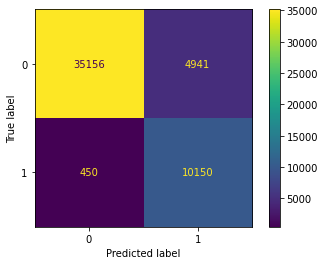

In [26]:
plot_confusion_matrix(clf_xgb,val_X,val_y, values_format= 'd')

In [27]:
val_y_pred = clf_xgb.predict(val_X)
val_y_pred_prob = clf_xgb.predict_proba(val_X)[: ,1]

print("validation: precision_score = " , precision_score(val_y,val_y_pred).round(3))
print("validation: recall_score = " ,    recall_score(val_y,val_y_pred).round(3))
print("validation: accuracy_score = " , accuracy_score(val_y,val_y_pred).round(3))
print("validation: f1_score = " , f1_score(val_y,val_y_pred).round(3))

validation: precision_score =  0.673
validation: recall_score =  0.958
validation: accuracy_score =  0.894
validation: f1_score =  0.79


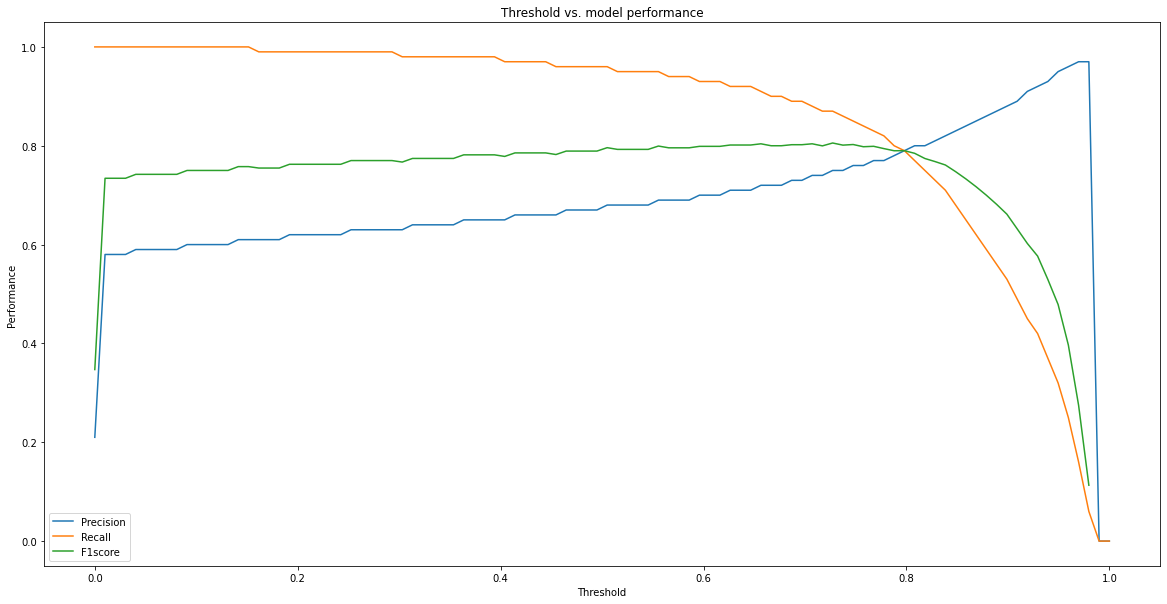

In [28]:
#Plot      
precision = []
recall = []
F1score = []
for i in np.linspace(0,1.01,100):
    precision_ = precision_score(val_y, val_y_pred_prob > i).round(2)
    recall_    = recall_score(val_y, val_y_pred_prob > i).round(2)    
    F1score_ = 2*(precision_*recall_)/(precision_ + recall_)
    precision.append(precision_)
    recall.append(recall_)
    F1score.append(F1score_)

    
threshold = list(np.linspace(0,1,100))
plt.figure(figsize=(20,10))
plt.plot(threshold, precision, label='Precision')
plt.plot(threshold, recall, label='Recall')
plt.plot(threshold, F1score, label='F1score')
plt.xlabel("Threshold")
plt.ylabel("Performance")
plt.title("Threshold vs. model performance")
plt.legend() 

In [29]:
print("validation@threshold0.80: precision_score = ", precision_score(val_y, val_y_pred_prob > 0.82).round(2))
print("validation@threshold0.80: recall_score = ", recall_score(val_y, val_y_pred_prob > 0.82).round(2))
print("validation@threshold0.80: accuracy_score = ", accuracy_score(val_y, val_y_pred_prob > 0.82).round(2))
print("validation@threshold0.80: f1_score = ", f1_score(val_y, val_y_pred_prob > 0.82).round(2))

validation@threshold0.80: precision_score =  0.8
validation@threshold0.80: recall_score =  0.76
validation@threshold0.80: accuracy_score =  0.91
validation@threshold0.80: f1_score =  0.78


In [ ]:
xgb_feat_imp_ = pd.DataFrame(train_X.columns, clf_xgb.feature_importances_)

xgb_feat_imp_.to_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/xgb_feat_imp_.xlsx")


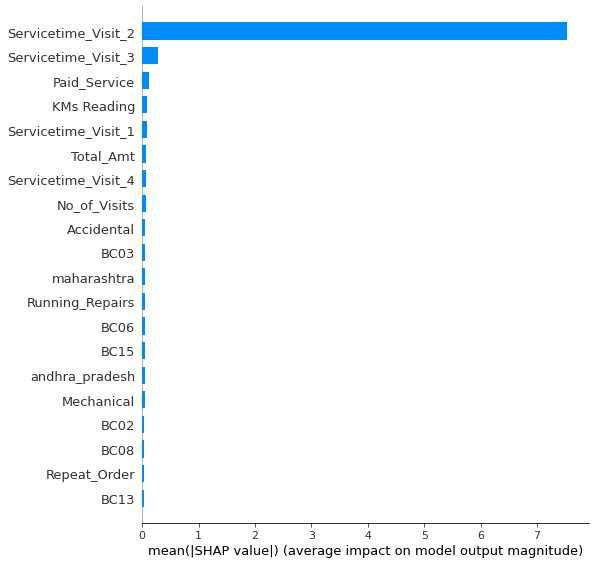

In [30]:
shap_values = shap.TreeExplainer(clf_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

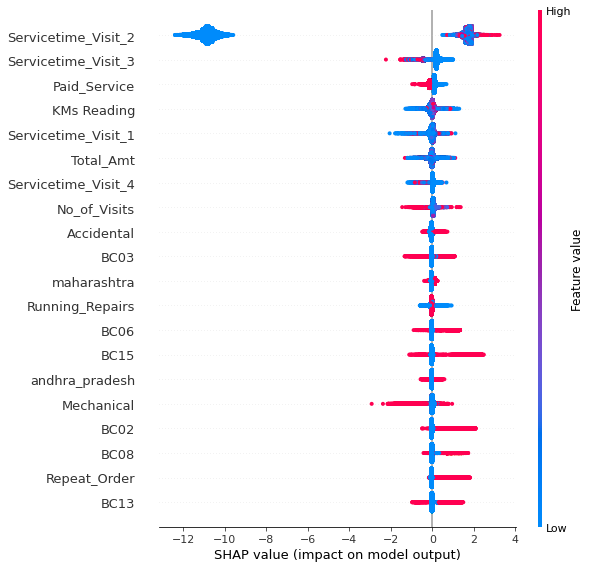

In [31]:
shap.summary_plot(shap_values, train_X)

In [1]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([train_X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df.sort_values('shap_importance', inplace= True)

In [33]:
train_X_col_list = train_X.columns.to_list()
append_str = '_SHAP'
suf_res = [sub + append_str for sub in train_X_col_list] 
shap_values_df = pd.DataFrame(shap_values)
shap_values_df.columns = suf_res

In [34]:
shap_values_df.columns.to_list()

['No_of_Visits_SHAP',
 'Accidental_SHAP',
 'Mechanical_SHAP',
 'Paid_Service_SHAP',
 'Repeat_Order_SHAP',
 'Running_Repairs_SHAP',
 'SMC_Redemption_SHAP',
 'SMC_Value_Package_SHAP',
 'WBW_Order_SHAP',
 'Workshop_Damage_SHAP',
 'andaman_and_nicobar_SHAP',
 'andhra_pradesh_SHAP',
 'arunachal_pradesh_SHAP',
 'assam_SHAP',
 'bihar_SHAP',
 'chandigarh_SHAP',
 'chhattisgarh_SHAP',
 'dadra_and_nagar_hav_SHAP',
 'daman_and_diu_SHAP',
 'delhi_SHAP',
 'goa_SHAP',
 'gujarat_SHAP',
 'haryana_SHAP',
 'himachal_pradesh_SHAP',
 'jammu_and_kashmir_SHAP',
 'jharkhand_SHAP',
 'karnataka_SHAP',
 'kerala_SHAP',
 'lakshadweep_SHAP',
 'madhya_pradesh_SHAP',
 'maharashtra_SHAP',
 'manipur_SHAP',
 'megalaya_SHAP',
 'mizoram_SHAP',
 'nagaland_SHAP',
 'odisha_SHAP',
 'puducherry_SHAP',
 'punjab_SHAP',
 'rajasthan_SHAP',
 'sikkim_SHAP',
 'tamil_nadu_SHAP',
 'telangana_SHAP',
 'tripura_SHAP',
 'uttar_pradesh_SHAP',
 'uttarakhand_SHAP',
 'west_bengal_SHAP',
 'BC01_SHAP',
 'BC02_SHAP',
 'BC03_SHAP',
 'BC04_SHAP',
 

In [35]:
train_X.reset_index(inplace= True)
shap_values_df_impfeat = shap_values_df[shap_values_df.columns.to_list()]
train_X_impfeat = train_X[train_X.columns.to_list()]
#train_X_impfeat.reset_index(inplace = True)
#Feat_shap_df = pd.concat([shap_values_df_impfeat,train_X_impfeat], axis =1 )

In [36]:
Feat_shap_df = pd.concat([shap_values_df_impfeat,train_X_impfeat], axis =1 )

In [ ]:
Feat = pd.DataFrame(Feat_shap_df.columns.to_list())

In [ ]:
Feat.to_excel("C:/Users/G550273/OneDrive - General Mills/Python/Greyatom/Greyatom Capstone Project/feat_.xlsx")

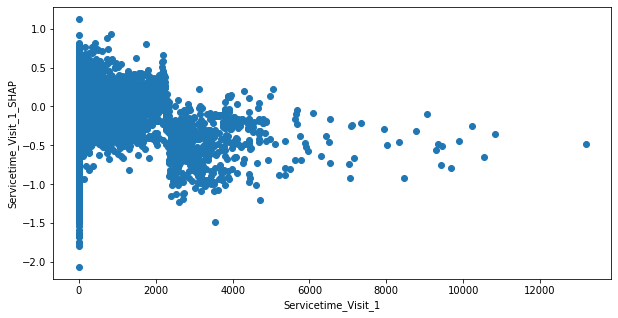

In [37]:
df_STV1 =  Feat_shap_df.loc[Feat_shap_df['Servicetime_Visit_1'] != 0]
plt.figure(figsize= (10,5))
plt.scatter( x = df_STV1['Servicetime_Visit_1'], y = df_STV1['Servicetime_Visit_1_SHAP'])
plt.xlabel('Servicetime_Visit_1')
plt.ylabel('Servicetime_Visit_1_SHAP')
plt.show()

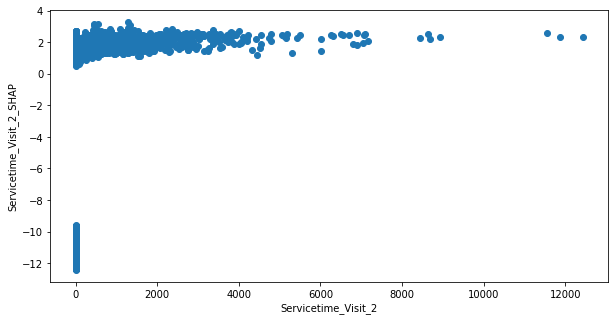

In [38]:
df_STV2 =  Feat_shap_df.loc[Feat_shap_df['Servicetime_Visit_2'] != 0]
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Servicetime_Visit_2'], y = Feat_shap_df['Servicetime_Visit_2_SHAP'])
plt.xlabel('Servicetime_Visit_2')
plt.ylabel('Servicetime_Visit_2_SHAP')
plt.show()

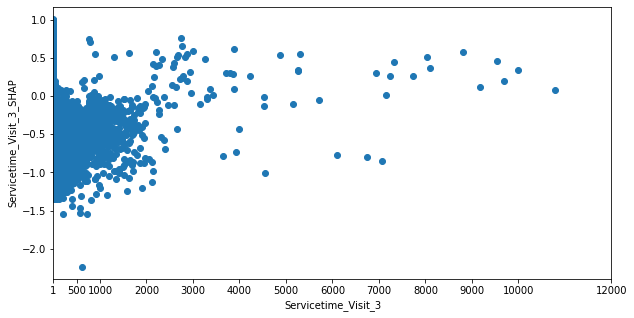

In [39]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Servicetime_Visit_3'], y = Feat_shap_df['Servicetime_Visit_3_SHAP'])
plt.xticks([1,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000])
#plt.xticks([5000,10000,25000, 50000,75000,100000,150000, 200000,250000,300000])
plt.xlim([1, 12000])
plt.xlabel('Servicetime_Visit_3')
plt.ylabel('Servicetime_Visit_3_SHAP')
plt.show()

In [2]:

plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['KMs Reading'], y = Feat_shap_df['KMs Reading_SHAP'])
plt.ticklabel_format(style='plain')
plt.xticks([5000,10000,25000, 50000,75000,100000,150000, 200000,250000,300000,350000,400000,450000,500000])
#plt.xticks([5000,10000,25000, 50000,75000,100000,150000, 200000,250000,300000])
plt.xlim([5000, 500000])
plt.xlabel('KMs Reading')
plt.ylabel('KMs Reading_SHAP')
plt.show()

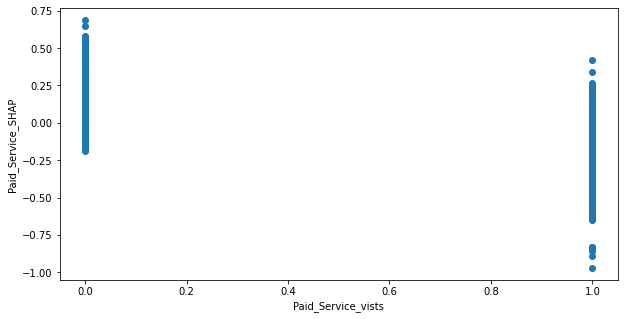

In [41]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Paid_Service'], y = Feat_shap_df['Paid_Service_SHAP'])
#plt.xticks([0, 25,50,100.150,200,250,300,350,400,450,500,550,600])
#plt.xlim([0, 600])
plt.xlabel('Paid_Service_vists')
plt.ylabel('Paid_Service_SHAP')
plt.show()

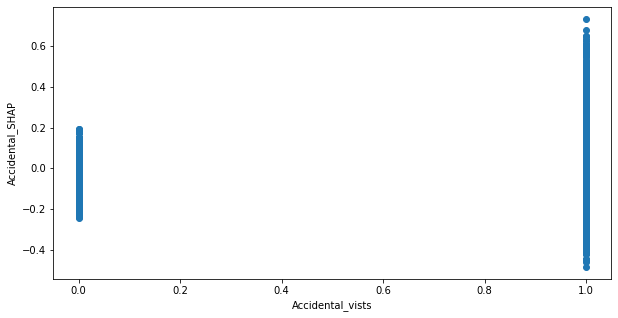

In [42]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Accidental'], y = Feat_shap_df['Accidental_SHAP'])
#plt.xticks([ 1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 80])
plt.xlabel('Accidental_vists')
plt.ylabel('Accidental_SHAP')
plt.show()

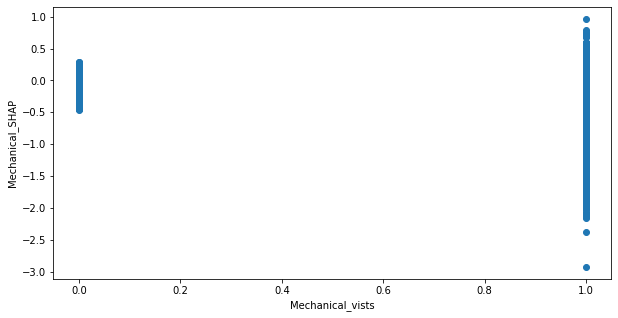

In [43]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Mechanical'], y = Feat_shap_df['Mechanical_SHAP'])
#plt.xticks([0, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([0, 100])
plt.xlabel('Mechanical_vists')
plt.ylabel('Mechanical_SHAP')
plt.show()

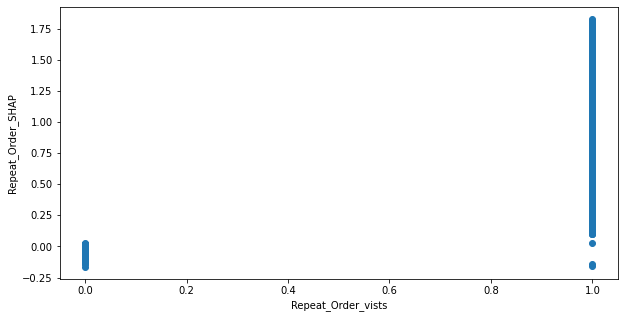

In [44]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Repeat_Order'], y = Feat_shap_df['Repeat_Order_SHAP'])
#plt.xticks([0, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([0, 100])
plt.xlabel('Repeat_Order_vists')
plt.ylabel('Repeat_Order_SHAP')
plt.show()

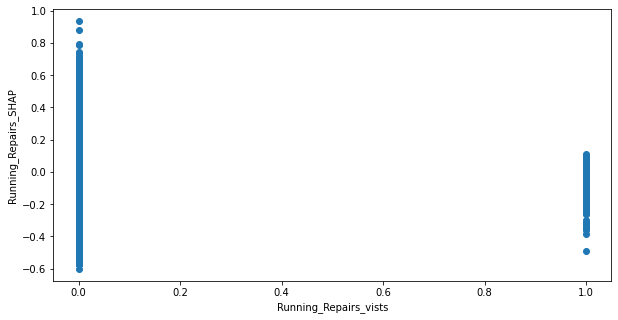

In [45]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Running_Repairs'], y = Feat_shap_df['Running_Repairs_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('Running_Repairs_vists')
plt.ylabel('Running_Repairs_SHAP')
plt.show()

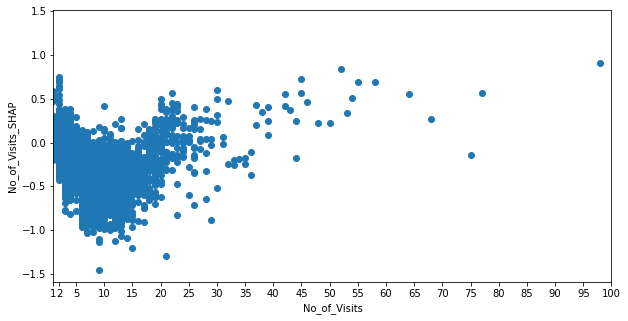

In [46]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['No_of_Visits'], y = Feat_shap_df['No_of_Visits_SHAP'])
plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
plt.xlim([1, 100])
plt.xlabel('No_of_Visits')
plt.ylabel('No_of_Visits_SHAP')
plt.show()

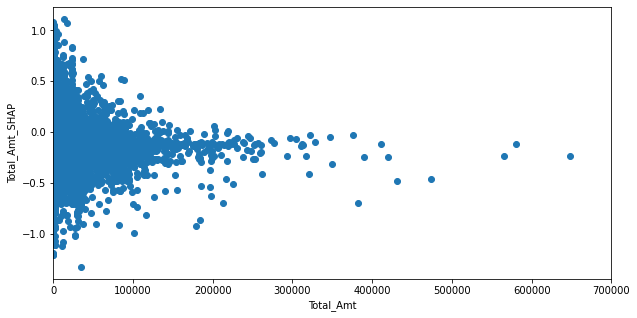

In [47]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['Total_Amt'], y = Feat_shap_df['Total_Amt_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
plt.xlim([0, 700000])
plt.xlabel('Total_Amt')
plt.ylabel('Total_Amt_SHAP')
plt.show()

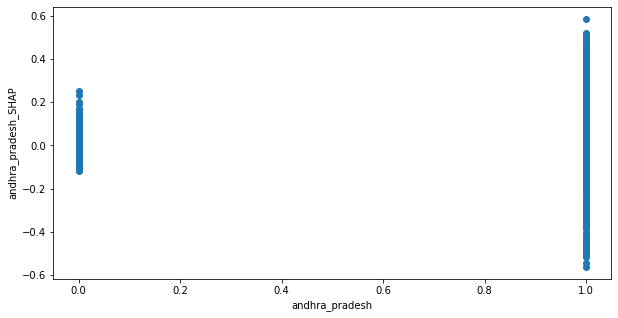

In [48]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['andhra_pradesh'], y = Feat_shap_df['andhra_pradesh_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('andhra_pradesh')
plt.ylabel('andhra_pradesh_SHAP')
plt.show()

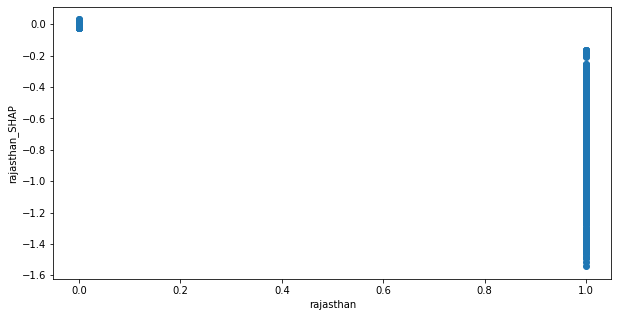

In [49]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['rajasthan'], y = Feat_shap_df['rajasthan_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('rajasthan')
plt.ylabel('rajasthan_SHAP')
plt.show()

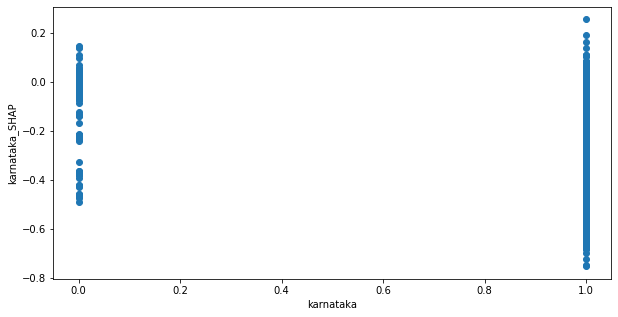

In [50]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['karnataka'], y = Feat_shap_df['karnataka_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('karnataka')
plt.ylabel('karnataka_SHAP')
plt.show()

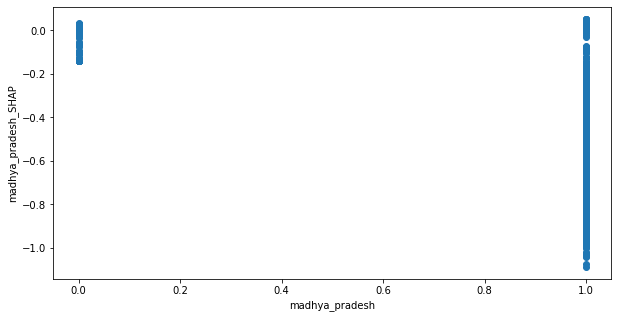

In [51]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['madhya_pradesh'], y = Feat_shap_df['madhya_pradesh_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('madhya_pradesh')
plt.ylabel('madhya_pradesh_SHAP')
plt.show()

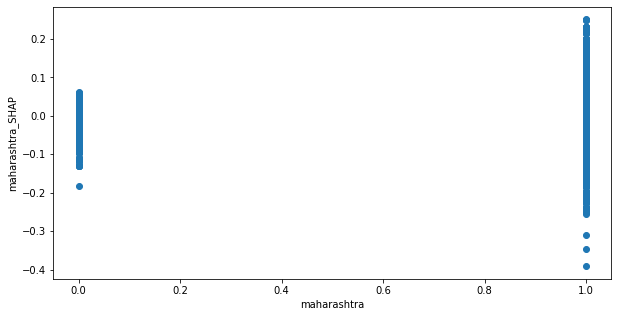

In [52]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['maharashtra'], y = Feat_shap_df['maharashtra_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('maharashtra')
plt.ylabel('maharashtra_SHAP')
plt.show()

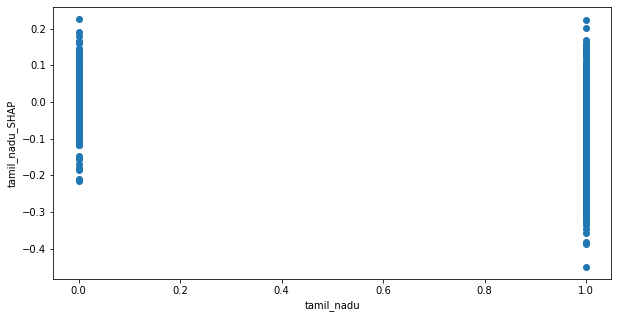

In [53]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['tamil_nadu'], y = Feat_shap_df['tamil_nadu_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('tamil_nadu')
plt.ylabel('tamil_nadu_SHAP')
plt.show()

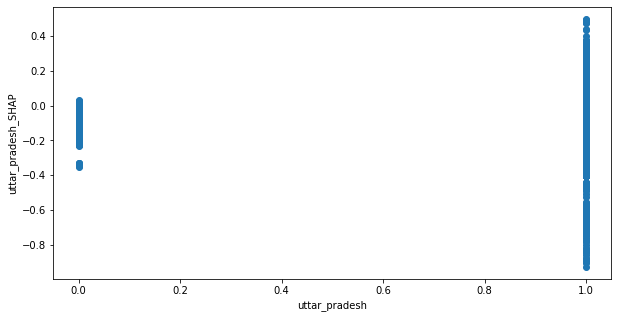

In [54]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['uttar_pradesh'], y = Feat_shap_df['uttar_pradesh_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('uttar_pradesh')
plt.ylabel('uttar_pradesh_SHAP')
plt.show()

In [ ]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['punjab'], y = Feat_shap_df['punjab_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('punjab')
plt.ylabel('punjab_SHAP')
plt.show()

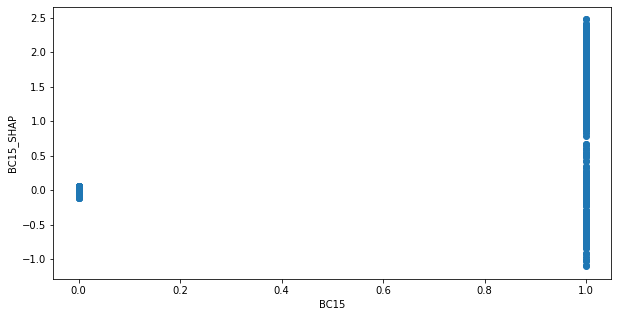

In [55]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC15'], y = Feat_shap_df['BC15_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC15')
plt.ylabel('BC15_SHAP')
plt.show()

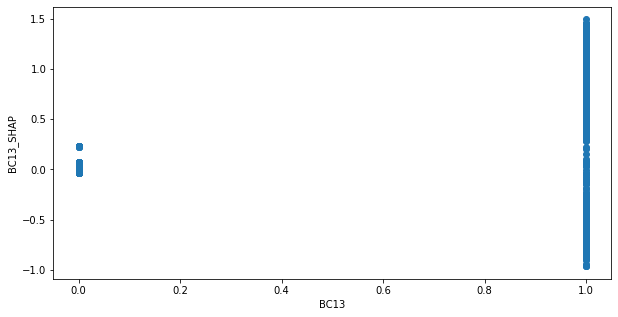

In [60]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC13'], y = Feat_shap_df['BC13_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC13')
plt.ylabel('BC13_SHAP')
plt.show()

In [ ]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC22'], y = Feat_shap_df['BC22_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC22')
plt.ylabel('BC22_SHAP')
plt.show()

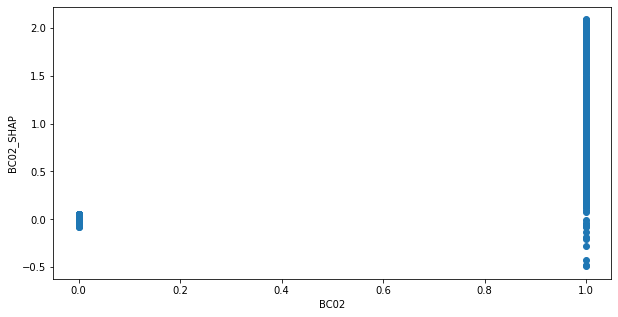

In [58]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC02'], y = Feat_shap_df['BC02_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC02')
plt.ylabel('BC02_SHAP')
plt.show()

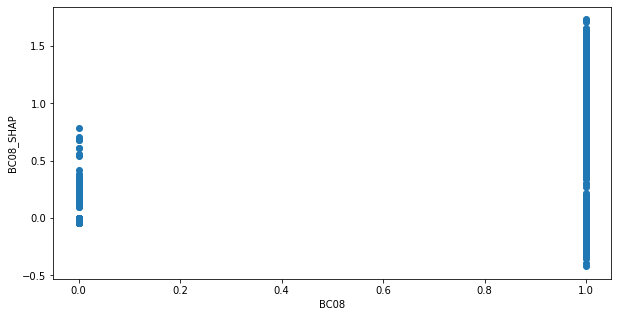

In [59]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC08'], y = Feat_shap_df['BC08_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC08')
plt.ylabel('BC08_SHAP')
plt.show()

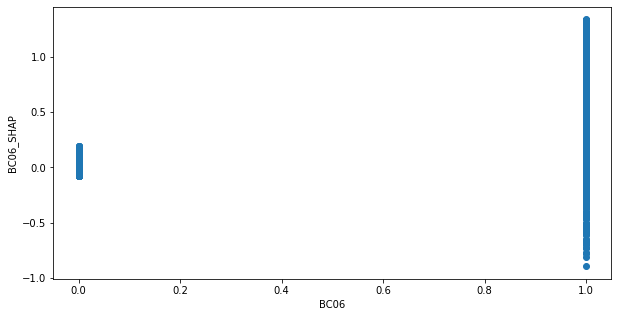

In [61]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC06'], y = Feat_shap_df['BC06_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC06')
plt.ylabel('BC06_SHAP')
plt.show()

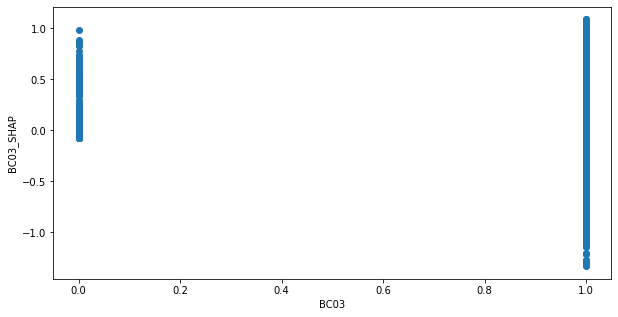

In [56]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC03'], y = Feat_shap_df['BC03_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC03')
plt.ylabel('BC03_SHAP')
plt.show()

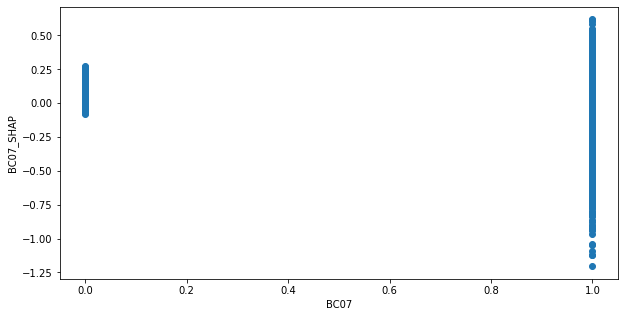

In [62]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC07'], y = Feat_shap_df['BC07_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC07')
plt.ylabel('BC07_SHAP')
plt.show()

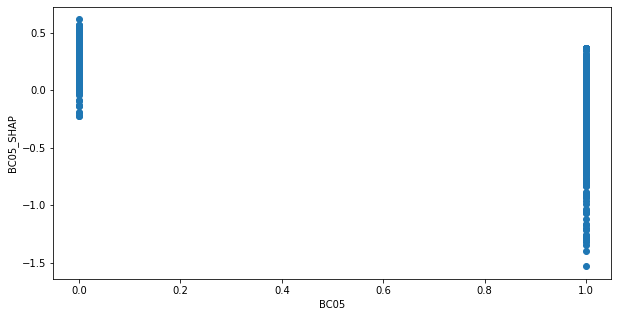

In [63]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC05'], y = Feat_shap_df['BC05_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC05')
plt.ylabel('BC05_SHAP')
plt.show()

In [ ]:
plt.figure(figsize= (10,5))
plt.scatter( x = Feat_shap_df['BC01'], y = Feat_shap_df['BC01_SHAP'])
#plt.xticks([1, 2, 5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
#plt.xlim([1, 100])
plt.xlabel('BC01')
plt.ylabel('BC01_SHAP')
plt.show()

# Model to predict CLTV Groups

In [33]:
X_ = modeldf_Cltv.iloc[ : , : -1]
y_ = modeldf_Cltv.iloc[ : , -1]
train_X_,val_X_,train_y_,val_y_ = train_test_split(X_, y_, test_size = 0.20, random_state = 42)

In [83]:
y_

0         1
1         3
2         3
3         2
4         1
         ..
253479    2
253480    3
253481    1
253482    3
253483    1
Name: clv_groups, Length: 253484, dtype: int64

In [34]:
train_X_.set_index('Customer No.', inplace= True)
val_X_.set_index('Customer No.', inplace= True)

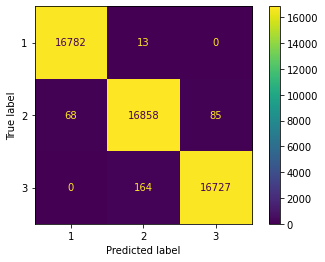

In [35]:
clf_xgb_mc = xgb.XGBClassifier(objective= 'multi:softprob',gamma= 0,
                             learning_rate= 0.3,
                             max_depth= 5,
                             n_estimators= 100,
                             reg_lambda= 1,
                              seed=2020)
clf_xgb_mc.fit(train_X_,train_y_,verbose = False, early_stopping_rounds = 10,eval_metric='mlogloss',eval_set =[(val_X_,val_y_)])

plot_confusion_matrix(clf_xgb_mc,val_X_,val_y_, values_format= 'd')

In [36]:
train_y__pred = clf_xgb_mc.predict(train_X_)
val_y__pred_prob = clf_xgb_mc.predict_proba(val_X_)
print(metrics.classification_report(train_y_, train_y__pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     67769
           2       0.99      0.99      0.99     67414
           3       1.00      0.99      0.99     67604

    accuracy                           0.99    202787
   macro avg       0.99      0.99      0.99    202787
weighted avg       0.99      0.99      0.99    202787



In [37]:
val_y__pred = clf_xgb_mc.predict(val_X_)
#val_y_pred_prob = clf_xgb.predict_proba(val_X_OHE)[: ,1]
print(metrics.classification_report(val_y_, val_y__pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     16795
           2       0.99      0.99      0.99     17011
           3       0.99      0.99      0.99     16891

    accuracy                           0.99     50697
   macro avg       0.99      0.99      0.99     50697
weighted avg       0.99      0.99      0.99     50697



Text(0.5, 0, 'Xgboost Feature Importance')

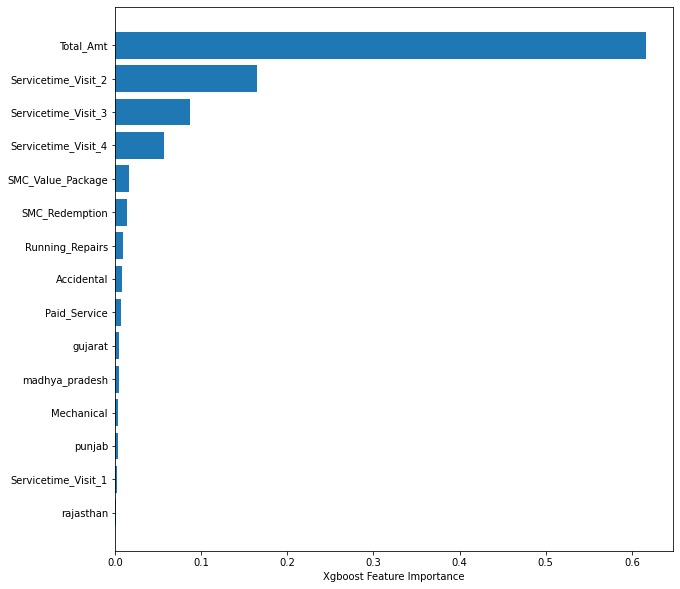

In [38]:
sorted_idx = clf_xgb_mc.feature_importances_.argsort()
plt.figure(figsize= (10,10))
plt.barh(train_X_.columns[sorted_idx], clf_xgb_mc.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

# CLTV Sensitivity model Log-Log model

In [ ]:
log_df1 = mod_df[['Customer No.','No_of_Visits']]

log_df2 = rfm_aliveprob_cltv[['Customer_ID','Frequency','MonetaryValue']]
log_df2.columns = ['Customer_ID', 'Frequency', 'MonetaryValue']

log_df3 = pd.pivot_table(df, values=['Hrs_servicetime', 'KMs Reading'], index=['Customer No.'],
                    aggfunc={'Hrs_servicetime': np.mean,
                             'KMs Reading': np.mean})

log_df4 = rfm_aliveprob_cltv[['Customer_ID','cust_lifetime_value']]
log_df4.columns = ['Customer No.', 'cust_lifetime_value']

log_df5 = modeldf_C[['Customer No.','Servicetime_Visit_1','Servicetime_Visit_2','Servicetime_Visit_3','Servicetime_Visit_4','km_read_Visit_1','km_read_Visit_2','km_read_Visit_3']]

log_df = reduce(lambda x,y: pd.merge(x,y, on='Customer No.', how='inner'), [log_df1,log_df2,log_df3,log_df4,log_df5])

In [ ]:
log_df.columns =['Unnamed', 'Customer_No', 'No_of_Visits', 'Frequency',
       'MonetaryValue', 'Hrs_servicetime', 'KMs_Reading',
       'cust_lifetime_value', 'Servicetime_Visit_1', 'Servicetime_Visit_2',
       'Servicetime_Visit_3', 'Servicetime_Visit_4', 'km_read_Visit_1',
       'km_read_Visit_2', 'km_read_Visit_3']

log_df['No_of_Visits']=log_df['No_of_Visits'].replace(0, 0.01)
log_df['Frequency']=log_df['Frequency'].replace(0, 0.01)
log_df['MonetaryValue']=log_df['MonetaryValue'].replace(0, 0.01)
log_df['Hrs_servicetime']=log_df['Hrs_servicetime'].replace(0, 0.01)
log_df['cust_lifetime_value']=log_df['cust_lifetime_value'].replace(0, 0.01)
log_df['KMs_Reading']=log_df['KMs_Reading'].replace(0, 0.01)
log_df['Servicetime_Visit_1']=log_df['Servicetime_Visit_1'].replace(0, 0.01)
log_df['Servicetime_Visit_2']=log_df['Servicetime_Visit_2'].replace(0, 0.01)
log_df['Servicetime_Visit_3']=log_df['Servicetime_Visit_3'].replace(0, 0.01)
log_df['Servicetime_Visit_4']=log_df['Servicetime_Visit_4'].replace(0, 0.01)
log_df['km_read_Visit_1']=log_df['km_read_Visit_1'].replace(0, 0.01)
log_df['km_read_Visit_2']=log_df['km_read_Visit_2'].replace(0, 0.01)
log_df['km_read_Visit_3']=log_df['km_read_Visit_3'].replace(0, 0.01)

reg = smf.ols(formula = 'np.log(cust_lifetime_value) ~  np.log(MonetaryValue) + np.log(Servicetime_Visit_1)  + np.log(Servicetime_Visit_2)+ np.log(Servicetime_Visit_3)+ np.log(Servicetime_Visit_4)+np.log(KMs_Reading)', data = log_df).fit()
reg.summary()